<a href="https://colab.research.google.com/github/jhasweta989/Computer_vision_transfer_learning/blob/main/Emergency_vehicle_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import dataset


In [ ]:
import numpy as np         #linear algebra
import pandas as pd        #read csv file
from tqdm import tqdm      #iteration over image file

In [ ]:
import matplotlib.pyplot as plt  #plot image 
%matplotlib inline

In [ ]:
from skimage.io import imread  #read image
from skimage.transform import resize   #resize image
from sklearn.model_selection import train_test_split   #split dataset into train and validate set

In [ ]:
data= pd.read_csv('/content/drive/My Drive/transfer learning/train.csv')  #read csv file

data['emergency_or_not]== 1 for emergency vehicle and 0 for non-emergency vehicle

In [ ]:
data.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


dataset has 1646 images

In [ ]:
data.shape

(1646, 2)

reduce dataset size to 950 images

In [ ]:
data= data[:950]

In [ ]:
data.shape

(950, 2)

412 emergency vehicle and 538 non emergency

In [ ]:
sum(data['emergency_or_not'])

412

In [ ]:
950-412

538

display a image from the dataset

In [ ]:
img= imread('/content/drive/My Drive/transfer learning/images/1.jpg')

In [ ]:
img.shape

(224, 224, 3)

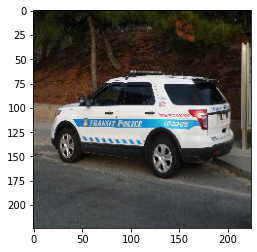

In [ ]:
plt.imshow(img)

preparing dataset for training model

In [ ]:
train_img=[]
for i_name in tqdm(data['image_names']):
  path= '/content/drive/My Drive/transfer learning/images/'+ i_name
  img= imread(path)
  img= img/255
  img= resize(img, output_shape=(224,224,3), mode='constant', anti_aliasing= True )
  img= img.astype('float32')
  train_img.append(img)


100%|██████████| 950/950 [05:39<00:00,  2.80it/s]


In [ ]:
train_x= np.array(train_img)

In [ ]:
train_x.shape

(950, 224, 224, 3)

In [ ]:
train_y= data['emergency_or_not'].values

In [ ]:
train_y.shape

(950,)

In [ ]:
# converting the target into torch format
train_y = train_y.astype(int)

split dataset into training and validation set

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state = 13, stratify=train_y)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

Import tensorflow and keras library for model creation

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

Import Xception pre-trained model

In [ ]:
model= keras.applications.Xception(input_shape=[224,224, 3], include_top=False, weights='imagenet')
model.trainable = False

83689472/83683744 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Modify pre-trained model according to our problem

In [ ]:
x = model.output
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
# and a sofymax/logistic layer -- we have 6 classes
x = Dense(16, activation='sigmoid')(x)
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
new_model = Model(inputs=model.input, outputs=predictions)

new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [ ]:
new_model.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy',
                           metrics = ['accuracy'])

train model

In [ ]:
checkpointer = ModelCheckpoint('/content/drive/My Drive/transfer learning/combined_Xception.model', 
    verbose=2, 
    save_best_only=True)
history = new_model.fit(
    train_x,train_y,
    validation_data=(val_x, val_y),
    epochs=100, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.6901
Epoch 00001: val_loss improved from inf to 0.56660, saving model to /content/drive/My Drive/transfer learning/combined_Xception.model
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/transfer learning/combined_Xception.model/assets
27/27 [==============================] - 21s 784ms/step - loss: 0.6407 - accuracy: 0.6901 - val_loss: 0.5666 - val_accuracy: 0.8316
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.8304
Epoch 00002: val_loss improved from 0.56660 to 0.48154, saving model to /content/drive/My Drive/transfer learning/combined_Xception.model
INFO:tensorflow:Assets written to: /content/drive/My Drive/trans

train time accuracy= 96.49%
validation time accuracy= 94.74%

use model to predict results for test dataset

In [ ]:
test= pd.read_csv('/content/drive/My Drive/transfer learning/test.csv')

In [ ]:
test.head()

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg


In [ ]:
test_img=[]
for i_name in tqdm(test['image_names']):
  path= '/content/drive/My Drive/transfer learning/images/'+ i_name
  img= imread(path)
  img= img/255
  img= resize(img, output_shape=(224,224,3), mode='constant', anti_aliasing= True )
  img= img.astype('float32')
  test_img.append(img)

100%|██████████| 706/706 [04:48<00:00,  2.44it/s]


In [ ]:
test_x= np.array(test_img)

In [ ]:
test_x.shape

(706, 224, 224, 3)

In [ ]:
pred= new_model.predict(test_x)

In [52]:
pred= np.where(pred>0.7, 1, 0)

In [53]:
sum(pred)

array([283])

In [54]:
sub= pd.read_csv("/content/drive/My Drive/transfer learning/submission.csv")

In [55]:
sub.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,0
2,2082.jpg,0
3,808.jpg,0
4,1907.jpg,0


In [56]:
sub['emergency_or_not']= pred

In [57]:
sub.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,1
4,1907.jpg,0


In [60]:
sub.to_csv('/content/drive/My Drive/transfer learning/submit.csv')